### Luminance from sky camera 1   2017-11-23 sw.-vers. 1

#### Remarks: This is at the very beginning of sky filming. At this point camera 2 was in construction.

In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import csv
import bisect
import datetime
from scipy import interpolate
from matplotlib.dates import DateFormatter

# User defined functions
from load_data_from_csv import *

#### Set observation time and date

In [2]:
day = '2017-11-23'   # select day of observation 
s_time = ' 07:00:00' # beginning and
e_time = ' 17:00' # end of observation
start = day + s_time
end   = day + e_time

#### Import Data from  Weather station at Luzern Switzerland

In [3]:
luz_csv = r'../weather_data/irradiation_luz_2017_2018.csv'

df = process_LUZ(luz_csv)
df.set_index(df.datetime, inplace=True)
df_lu = df['gre000z0']       # 10 min mean in W/m² 
lu_rad = df_lu.loc[start:end]   # set distinct observation day
#lu_rad.head(n=2)

#### Import Data from Weather station at Lucerne University of Applied Sciences and Arts, Switzerland (HSLU)

In [4]:
hslu_csv = r'../weather_data/CH_LU_Horw_HSLU_SolarIrradiation_2017.csv'

df = process_HSLU(hslu_csv)
df.set_index(df.datetime, inplace=True)
df_hslu = df['GHI_Avg']             # 1 min mean in W/m² 
hslu_rad = df_hslu.loc[start:end]   # set distinct observation day
#hslu_rad.head(n=2)

#### Load relative luminance from images

In [5]:
calc_csv = r'../lumi_data/20171123_cam1_luminance.csv'

df_calc = process_LUMI(calc_csv)
lum_hdr = df_calc['lum_hdr']          # mean luminance from HDR image
lum_hdr_m = df_calc['lum_hdr_m']      # mean luminance from masked HDR image from raw data
lum_jpg_m = df_calc['lum_jpg_m']      # mean luminance from masked HDR image build from three jpg exposures
#lum_hdr.head(n=2)

#### Load irradiance data for McClear model

In [6]:
soda_csv = r'../weather_data/irradiation_soda_2017_2018_1min.csv'

df = process_SODA(soda_csv)
df_soda = df['Clear sky GHI']*60      # given in units of Wh/m² 
mc_rad = df_soda.loc[start:end]       # set distinct observation day
#mc_rad.head(n=2)

#### Pyranometer measurements vs. McClear model on 2017-11-23

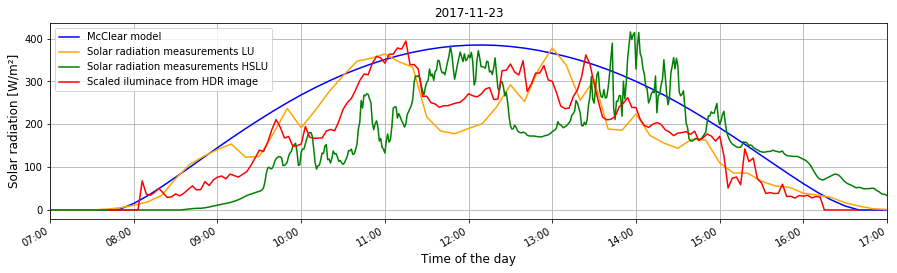

In [7]:
matplotlib.rcParams['timezone'] = 'Europe/Zurich'

fig = plt.figure(1, figsize=(15,4))
mc_rad.plot(label='McClear model', color='blue')
lu_rad.plot(label='Solar radiation measurements LU', color='orange')

lum_hdr_scaled = lum_hdr/50
hslu_rad.plot(label='Solar radiation measurements HSLU', color='green')
lum_hdr_scaled.plot(label='Scaled iluminace from HDR image', color='red')

plt.xlabel('Time of the day', fontsize=12)
plt.ylabel('Solar radiation [W/m²]', fontsize=12)
plt.legend(loc='upper left')
plt.grid(b=None, which='major', axis='both')
plt.title(day)
fig.autofmt_xdate()
formatter = DateFormatter('%H:%M')
#formatter.set_tzinfo(timezone('Europe/Zurich'))
plt.gcf().axes[0].xaxis.set_major_formatter(formatter)

#### Normalized values including luminance data

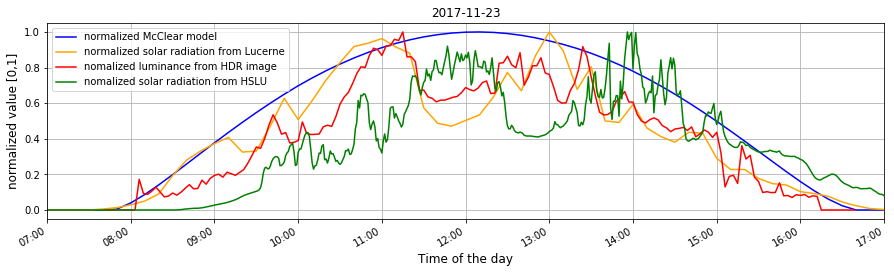

In [8]:
# Set appropriate timezone
matplotlib.rcParams['timezone'] = 'Europe/Zurich'

day = '2017-11-23'   # day of observation ('2017-11-23' : camera 1, sw-vers. 1)
s_time = ' 7:00:00'  # beginning of observation
e_time = ' 17:00:00' # end of observation
start  = day + s_time
end    = day + e_time

lu_rad   = df_lu.loc[start:end]      # weather station in Lucerne
hslu_rad = df_hslu.loc[start:end]    # weather station at University of Applied Sciences and Arts in Lucerne (HSLU)
mc_rad   = df_soda.loc[start:end]    # McClear model

lu_rad_n   = ((lu_rad-lu_rad.min())/(lu_rad.max()-lu_rad.min()))
mc_rad_n   = ((mc_rad-mc_rad.min())/(mc_rad.max()-mc_rad.min()))
lum_hdr_n  = ((lum_hdr-lum_hdr.min())/(lum_hdr.max()-lum_hdr.min()))
hslu_rad_n = ((hslu_rad-hslu_rad.min())/(hslu_rad.max()-hslu_rad.min()))

fig = plt.figure(2, figsize=(15,4))
mc_rad_n.plot(label ='normalized McClear model', color='blue')
lu_rad_n.plot(label ='normalized solar radiation from Lucerne', color='orange')
lum_hdr_n.plot(label='nomalized luminance from HDR image', color='red')
hslu_rad_n.plot(label='nomalized solar radiation from HSLU', color='green')

plt.xlabel('Time of the day', fontsize=12)
plt.ylabel('normalized value [0,1]', fontsize=12)
plt.legend(loc='upper left')
plt.grid(b=None, which='major', axis='both')
plt.title(day)
fig.autofmt_xdate()
formatter = DateFormatter('%H:%M')
plt.gcf().axes[0].xaxis.set_major_formatter(formatter)

#### Scatter plot  luminance from HDR images vs. measured solar irradiance

lum_hdr_scaled: 180 hslu_rad_ip: 180
Correlation =  0.4939798127499454


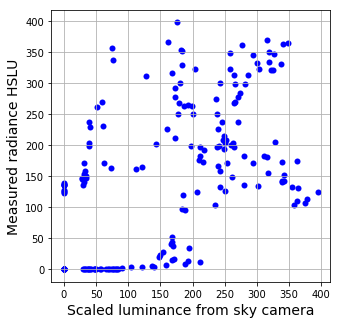

In [9]:
fig = plt.figure(3, figsize=(15,4))

day = '2017-11-23'   # day of observation ('2018-10-12' : camera 2, sw-vers. 3)
s_time = ' 07:00:00' # beginning of observation
e_time = ' 17:00:00' # end of observation
start = day + s_time
end   = day + e_time

hslu_rad_f  = hslu_rad.asfreq(freq='3Min')
hslu_rad_ip = hslu_rad_f.interpolate(method='linear')
#hslu_rad_ip.head(n=4)
hslu_rad_ip = hslu_rad_ip[:-21]
print('lum_hdr_scaled: {} hslu_rad_ip: {}'.format(lum_hdr_scaled.size, hslu_rad_ip.size)) # hslu_rad_ip

plt.figure(10,figsize=(5,5))
plt.scatter(x=lum_hdr_scaled, y=hslu_rad_ip, marker='o', linewidths=0.01 , color='blue') # lum_hdr_n
plt.grid(b=None, which='major', axis='both')

plt.xlabel('Scaled luminance from sky camera', fontsize=14)
plt.ylabel('Measured radiance HSLU', fontsize=14)

r = np.corrcoef(lum_hdr_scaled, hslu_rad_ip)    # lu_rad_n
print ('Correlation = ', r[0][1])

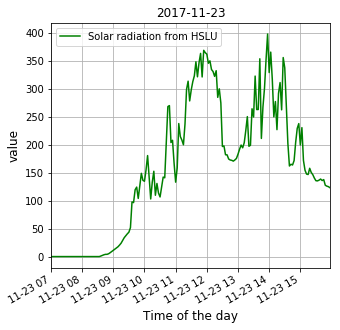

In [10]:
fig = plt.figure(11, figsize=(5,5))

hslu_rad_ip.plot(label='Solar radiation from HSLU', color='green')
plt.xlabel('Time of the day', fontsize=12)
plt.ylabel('value', fontsize=12)
plt.legend(loc='upper left')
plt.grid(b=None, which='major', axis='both')
plt.title(day)
formatter = DateFormatter('%H:%M')
#plt.gcf().axes[0].xaxis.set_major_formatter(formatter)

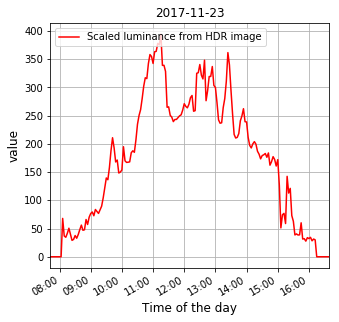

In [11]:
fig = plt.figure(12, figsize=(5,5))

lum_hdr_scaled.plot(label='Scaled luminance from HDR image', color='red')
plt.xlabel('Time of the day', fontsize=12)
plt.ylabel('value', fontsize=12)
plt.legend(loc='upper left')
plt.grid(b=None, which='major', axis='both')
plt.title(day)
fig.autofmt_xdate()
formatter = DateFormatter('%H:%M')
plt.gcf().axes[0].xaxis.set_major_formatter(formatter)

#### http://heather.cs.ucdavis.edu/~matloff/rpy2.html